In [8]:
from fastai.collab import *
from fastai.tabular import *
import numpy as np

In [9]:
from fastai.vision import *
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#root_dir = "/content/gdrive/.../data/ml-latest-small/"

In [10]:
path = Path(root_dir)
path.ls()

NameError: name 'Path' is not defined

In [4]:
user,item,title = 'userId','movieId','title'
ratings = pd.read_csv(path/'ratings.csv', delimiter=',')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
GENRES = [
    'Action', 'Adventure', 'Animation', "Children", 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', "IMAX", 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

genres='genres'
movies = pd.read_csv(path/'movies.csv',skiprows=1 ,names=[item,title,genres])

In [ ]:
def _map_fn(entry):
  movie_genres = entry.split("|")
  output = np.zeros((len(GENRES),), dtype=np.int64)
  for i, genre in enumerate(GENRES):
    if genre in movie_genres:
      output[i] = 1

  return output

In [7]:
movies['cs']=movies[genres].apply(_map_fn)

for j,genre in enumerate(GENRES):
  for i, row in movies.iterrows():
    movies.loc[i,genre]=row['cs'][j]
                            
movies.head()

,movieId,title,genres,cs,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy|Romance,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),Comedy,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
len(ratings)

100836

In [9]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [ ]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [11]:
data.show_batch()

userId,title,target
606,Death and the Maiden (1994),3.5
222,Ocean's Twelve (2004),2.5
75,Titanic (1997),2.5
59,Taxi Driver (1976),5.0
219,Cowboy Bebop: The Movie (Cowboy Bebop: Tengoku no Tobira) (2001),3.5


In [ ]:
y_range = [0,5.5]

In [ ]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


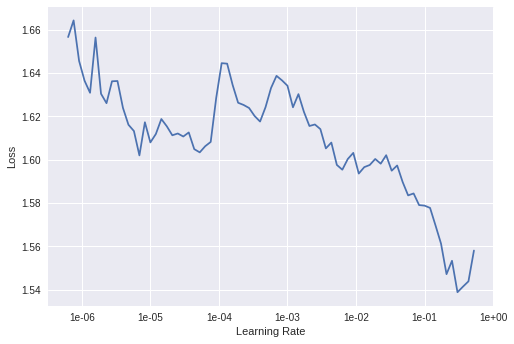

In [14]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [15]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
1,0.804215,0.777113,00:21
2,0.725118,0.718006,00:34
3,0.589973,0.694228,00:34
4,0.469293,0.680382,00:31
5,0.378436,0.682010,00:26


In [ ]:
learn.save('-2')

In [ ]:
learn.load('-2');

In [ ]:
w = learn.model.u_weight.weight.cpu() #40 factors for 611 users 
b = learn.model.u_bias.weight.cpu() #bias for 611 users
print(w.shape,b.shape)

In [ ]:
u = torch.cat([w,b],1) #bias as 41st element
# print(b)
print(u)

In [ ]:
user_factors = u.detach().numpy()
# print(u.shape,user_factors.shape,u,user_factors)
movies_weights = learn.model.i_weight.weight.cpu()
movies_bias= learn.model.i_bias.weight.cpu()

print(movies_weights.shape,movies_bias.shape) #9352 films
movies_f = torch.cat([movies_weights,movies_bias],1)

In [ ]:
movies_factors = movies_f.detach().numpy() #as numpy array
print(movies_f.shape,movies_factors.shape,movies_f,movies_factors)

In [ ]:
u@torch.t(movies_f)

In [ ]:
# movieId, rating
import numpy as np
lists = np.array([[1,5],[87,2],[23,1],[13,3]]) # (kx1), movieId zaczyna od 1, czyli filtrujemy indexach macierzy

 #funkcja Tworzymy macierz 600x20 - uzytkownicy na liczba filmow.
# 3. Liczymy pearsona 600x20 razy 20x1, dostajemy wektor 600x1, wyznaczamy top 10 (t) uzytkownikow.
# 4. Macierz 10x1, znajdujemy userid
# 5. Bierzemy 10x40 embeddings matrix i liczymy srednia, dostajemy wektor 1x40
# 6. Mnozymy 1x40 przez 40x10000 dostajemy 1x10000
# 7. Sortujemy, wyznaczamy top 20 bez obejrzanych
# return [[2,4.2],[3,2],[12,3]]

In [ ]:
w = learn.model.u_weight.weight.cpu() #40 factors for 611 users 
b = learn.model.u_bias.weight.cpu() #bias for 611 users
# print(w.shape,b.shape)
u = torch.cat([b,w],1) #bias as 1st element
# print(b)
# print(u)

user_factors = u.detach().numpy()
# print(u.shape,user_factors.shape,u,user_factors)
movies_weights = learn.model.i_weight.weight.cpu()
movies_bias= learn.model.i_bias.weight.cpu()

# print(movies_weights.shape,movies_bias.shape) #9352 films
movies_f = torch.cat([movies_bias, movies_weights],1)
movies_factors = movies_f.detach().numpy() #as numpy array
# print(movies_f.shape,movies_factors.shape,movies_f,movies_factors)


matrix=u@torch.t(movies_f)
# print(matrix)
# matrix.shape

def get_movies(lists): 
  global movies_factors, matrix, u
  lists = np.array(sorted(lists, key=lambda a_entry: a_entry[0]))  #sortowanie po movieId
  movie_ids=lists[:,0]
  movie_ratings=lists[:,1]
  
 #funkcja Tworzy macierz 600x20 - uzytkownicy na liczba filmow.    
  reduced_matrix=matrix[:,movie_ids]
  
  y_range=[0.5,5.5]
  ratings=torch.sigmoid(reduced_matrix) * (y_range[1]-y_range[0]) + y_range[0]

  from scipy.stats.stats import pearsonr 

# 3. Liczymy pearsona 600x20 razy 20x1, dostajemy wektor 600x1, wyznaczamy top 10 (t) uzytkownikow.
  tmp = np.array([])
  for ind, i in enumerate(ratings):
    p_coeff=pearsonr(movie_ratings,i.numpy())[0]
    tmp=np.append(tmp,p_coeff)
  
  top10_users=np.argsort(tmp)[-10:]
#   print(top10_users) # 4. Macierz 10x1, znajdujemy userid
    
  reduced_users_matrix=u[top10_users]
  reduced_users_matrix.shape

  mean_vec=np.mean(reduced_users_matrix.numpy(),axis=0)
  mean_vec=torch.tensor(mean_vec)[None]

  movies_factors=torch.tensor(movies_factors)

  result=mean_vec@torch.t(movies_factors)
  
  top30_films=np.argsort(result)[0][-(len(movie_ids)+20):]
  top30_films=reversed(top30_films)
  movie_ids=torch.tensor(movie_ids)

  top10=np.array([])
  for i in range(len(top30_films)):
    if len(top10)<10:
      if top30_films[i] not in movie_ids:
        top10=np.append(top10,top30_films[i]+1)
  return(top10)


In [ ]:
lists = np.array([[1,5],[87,2],[23,1],[13,3]])
top10=get_movies(lists)
print(top10)

In [ ]:
import pickle

with open('movie_recommendation.pickle', 'wb') as handle:
    pickle.dump((matrix,u,movies_factors), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('movie_recommendation.pickle', 'rb') as handle:
    matrix,u,movies_factors = pickle.load(handle)
    
print(u)